# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [53]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, roc_curve, auc
import time
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [4]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

The task in hand is to evaluate multiple model types and find the best that predicts whether or not a Portugese bank client will subscribe a term deposit.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

We need to take care of any data that is not numeric.  Given the description of the features above, we can encode each feature to be numeric.  Let's build a column transformer to modify all our columns.  While we're at it, let's scale our numeric data

In [ ]:
transformer = ColumnTransformer(
transformers = [
    ('onehot', OneHotEncoder(sparse_output=False), ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']),
    ('scaler', StandardScaler(), ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'])
])
y = df['y'].apply(lambda x: 1 if x == 'yes' else 0)

transformer.set_output(transform='pandas')
X = transformer.fit_transform(df.drop('y', axis=1))

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [30]:
dummy = DummyClassifier()
start_time = time.time()
dummy.fit(X_train, y_train)
end_time = time.time()
dummy_time = end_time - start_time
dummy_train_score = dummy.score(X_train, y_train)
dummy_test_score = dummy.score(X_test, y_test)
print(dummy_test_score)

0.8872487132174419


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [31]:
log = LogisticRegression()
start_time = time.time()
log.fit(X_train, y_train)
end_time = time.time()
log_time = end_time - start_time

### Problem 9: Score the Model

What is the accuracy of your model?

In [32]:
log_train_score = log.score(X_train, y_train)
log_test_score = log.score(X_test, y_test)
print(log_test_score)

0.9125959017189472


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [33]:
knn = KNeighborsClassifier()
start_time = time.time()
knn.fit(X_train, y_train)
end_time = time.time()
knn_time = end_time - start_time
knn_train_score = knn.score(X_train, y_train)
knn_test_score = knn.score(X_test, y_test)
print(knn_test_score)

0.9051179955326795


In [34]:
dtree = DecisionTreeClassifier()
start_time = time.time()
dtree.fit(X_train, y_train)
end_time = time.time()
dtree_time = end_time - start_time
dtree_train_score = dtree.score(X_train, y_train)
dtree_test_score = dtree.score(X_test, y_test)
print(dtree_test_score)

0.8920073807905216


In [35]:
svm = SVC()
start_time = time.time()
svm.fit(X_train, y_train)
end_time = time.time()
svm_time = end_time - start_time
svm_train_score = svm.score(X_train, y_train)
svm_test_score = svm.score(X_test, y_test)
print(svm_test_score)

0.9114305137418666


In [36]:
model_df = pd.DataFrame({ 'Model' : ['Dummy', 'Logistic Regression', 'K-Nearest Neighbors', 'Decision Tree', 'Support Vector Machine'],
                          'Training Time (s)' : [dummy_time, log_time, knn_time, dtree_time, svm_time],
                          'Train Score' : [dummy_train_score, log_train_score, knn_train_score, dtree_train_score, svm_train_score],
                          'Test Score' : [dummy_test_score, log_test_score, knn_test_score, dtree_test_score, svm_test_score] })
print(model_df)

                    Model  Training Time (s)  Train Score  Test Score
0                   Dummy           0.000993     0.887378    0.887249
1     Logistic Regression           0.072131     0.910265    0.912596
2     K-Nearest Neighbors           0.012265     0.929462    0.905118
3           Decision Tree           0.139761     1.000000    0.892007
4  Support Vector Machine           7.719081     0.920462    0.911431


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.


- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

Now let's tune each model's hyperparameters.  We will use GridSearchCV.

In [ ]:
#log_params = { 'C' : [0.01, 0.1, 1, 10, 100],
#               'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
#               'fit_intercept' : [True, False],
#               'max_iter' : [100, 200, 500, 750, 1000] }
#
#log_grid = GridSearchCV(LogisticRegression(), log_params, cv=5, n_jobs=-1, verbose=1)
#log_grid.fit(X_train, y_train)

# This grid search took ~2.5 minutes to run
# The best parameters were:
# {'C': 1, 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


C:\Users\neilh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
3250 fits failed out of a total of 5000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
250 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\neilh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\neilh\AppData\Local\Packages\PythonSoftwareFou

,estimator,LogisticRegression()
,param_grid,"{'C': [0.01, 0.1, ...], 'fit_intercept': [True, False], 'max_iter': [100, 200, ...], 'penalty': ['l1', 'l2', ...], ...}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [ ]:
# Print the best parameters of the grid search
# print(log_grid.best_params_)

{'C': 1, 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}


In [ ]:
#knn_params = { 'n_neighbors' : range(3, 11),
#               'weights' : ['uniform', 'distance'],
#               'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
#               'p' : [1, 2],
#               'metric' : ['euclidean', 'manhattan'] }
#
#knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, n_jobs=-1, verbose=1)
#knn_grid.fit(X_train, y_train)

# This grid search took ~ 11min to run
# The best parameters found were:
# {'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 9, 'p': 1, 'weights': 'distance'}

Fitting 5 folds for each of 256 candidates, totalling 1280 fits


,estimator,KNeighborsClassifier()
,param_grid,"{'algorithm': ['auto', 'ball_tree', ...], 'metric': ['euclidean', 'manhattan'], 'n_neighbors': range(3, 11), 'p': [1, 2], ...}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_neighbors,9


In [ ]:
# Print the best parameters of the grid search
# print(knn_grid.best_params_)

{'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 9, 'p': 1, 'weights': 'distance'}


In [ ]:
#dtree_params = { 'criterion' : ['gini', 'entropy', 'log_loss'],
#                 'splitter' : ['best', 'random'],
#                 'max_depth' : [10, 20, 30, 40, 50],
#                 'min_samples_split' : [2, 5, 10],
#                 'min_samples_leaf' : [1, 2, 4, 8],
#                 'max_features' : ['auto', 'sqrt', 'log2'] }
#
#dtree_grid = GridSearchCV(DecisionTreeClassifier(), dtree_params, cv=5, n_jobs=-1, verbose=1)
#dtree_grid.fit(X_train, y_train)

# To save time, we will comment out the decision tree grid search
# The best parameters found were:
# {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 5, 'splitter': 'best'}

Fitting 5 folds for each of 1080 candidates, totalling 5400 fits


C:\Users\neilh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
1800 fits failed out of a total of 5400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1236 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\neilh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\neilh\AppData\Local\Packages\PythonSoftwareFo

,estimator,DecisionTreeClassifier()
,param_grid,"{'criterion': ['gini', 'entropy', ...], 'max_depth': [10, 20, ...], 'max_features': ['auto', 'sqrt', ...], 'min_samples_leaf': [1, 2, ...], ...}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [ ]:
# Print the best parameters of the grid search
print(dtree_grid.best_params_)

{'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 5, 'splitter': 'best'}


In [ ]:
#svm_params = { 'C' : [0.1, 1, 10, 100],
#               'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
#               'degree' : [2, 3, 4, 5],
#               'gamma' : ['scale', 'auto'] }
#
#svm_grid = GridSearchCV(SVC(), svm_params, cv=5, n_jobs=-1, verbose=1)
#svm_grid.fit(X_train, y_train)

# This grid search takes a long time to run ~55 minutes
# The best parameters found were:
# {'C': 10, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}

Fitting 5 folds for each of 128 candidates, totalling 640 fits


,estimator,SVC()
,param_grid,"{'C': [0.1, 1, ...], 'degree': [2, 3, ...], 'gamma': ['scale', 'auto'], 'kernel': ['linear', 'poly', ...]}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,10


In [ ]:
# Print the best parameters of the grid search
#print(svm_grid.best_params_)

{'C': 10, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}


Note that the grid searches were run.  However, to save time running this notebook later, I'll create the 'best_estimator_' for each model below for further evaluation.

In [50]:
# Create the best estimators based on the grid search results
log_estimator = LogisticRegression(C=1, fit_intercept=True, max_iter=100, penalty='l2', solver='liblinear').fit(X_train, y_train)
knn_estimator = KNeighborsClassifier(algorithm='auto', metric='euclidean', n_neighbors=9, p=1, weights='distance').fit(X_train, y_train)
dtree_estimator = DecisionTreeClassifier(criterion='gini', max_depth=10, max_features='sqrt', min_samples_leaf=8, min_samples_split=5, splitter='best').fit(X_train, y_train)
svm_estimator = SVC(C=10, degree=2, gamma='auto', kernel='rbf').fit(X_train, y_train)


In [52]:
# Evaluate the improvements of the best estimators
log_best_train_score = log_estimator.score(X_train, y_train)
log_best_test_score = log_estimator.score(X_test, y_test)
knn_best_train_score = knn_estimator.score(X_train, y_train)
knn_best_test_score = knn_estimator.score(X_test, y_test)
dtree_best_train_score = dtree_estimator.score(X_train, y_train)
dtree_best_test_score = dtree_estimator.score(X_test, y_test)
svm_best_train_score = svm_estimator.score(X_train, y_train)
svm_best_test_score = svm_estimator.score(X_test, y_test)

best_data = pd.DataFrame({ 'Model' : ['Logistic Regression', 'K-Nearest Neighbors', 'Decision Tree', 'Support Vector Machine'],
                           'Train Score' : [log_best_train_score, knn_best_train_score, dtree_best_train_score, svm_best_train_score],
                           'Test Score' : [log_best_test_score, knn_best_test_score, dtree_best_test_score, svm_best_test_score],
                           'Improvement in Test Score' : [log_best_test_score - log_test_score,
                                                          knn_best_test_score - knn_test_score,
                                                          dtree_best_test_score - dtree_test_score,
                                                          svm_best_test_score - svm_test_score ] })
print(best_data)

                    Model  Train Score  Test Score  Improvement in Test Score
0     Logistic Regression     0.910297    0.912596                   0.000000
1     K-Nearest Neighbors     1.000000    0.903079                  -0.002039
2           Decision Tree     0.912499    0.907060                   0.015053
3  Support Vector Machine     0.921692    0.910945                  -0.000486


As you can see above, some of the test scores decreased from the default.  This is likely due to the grid search parameters being too coarse and us missing the optimal parameters.
We could rerun the grid search more fine around the defaults or around the current 'best' parameters.  This may not really give us much improvement for the time.  The accuracy
scores weren't far off.  Let's keep going.  Let's take a look at the ROC curve and the confusion matrix for the models.

Text(0.5, 1.0, 'Confusion Matrix - Logistic Regression')

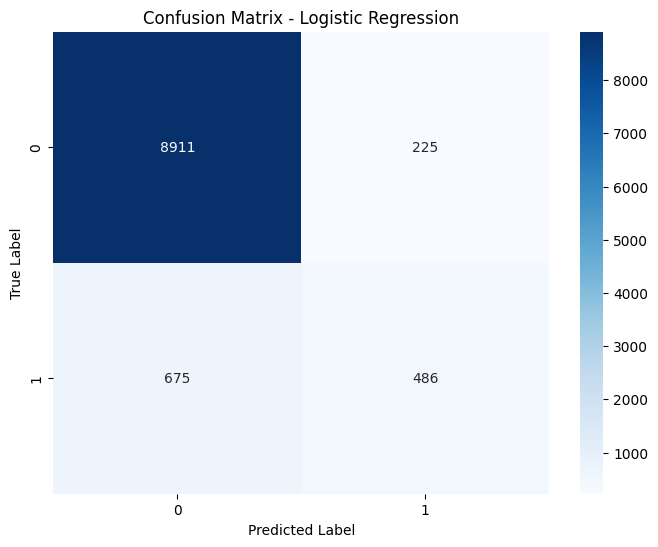

In [57]:
# Build the confusion matrix for Logistic Regression
conf_matrix_log = confusion_matrix(y_test, log_estimator.predict(X_test))
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_log, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Logistic Regression')

Text(0.5, 1.0, 'Confusion Matrix - K-Nearest Neighbors')

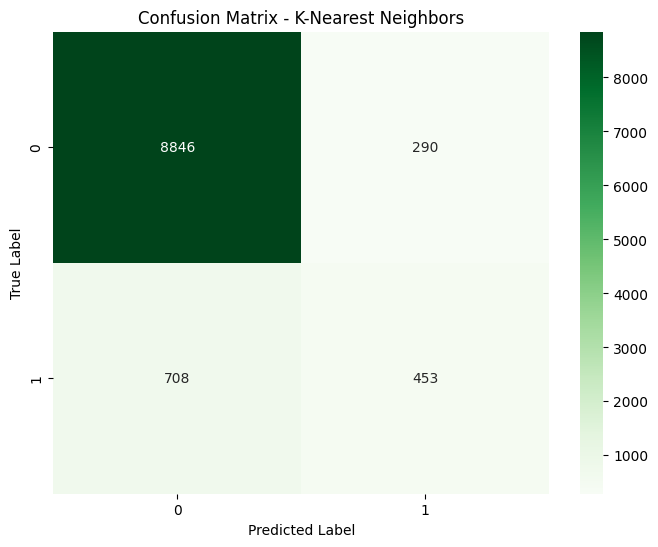

In [58]:
# Build the confusion matrix for K-Nearest Neighbors
conf_matrix_knn = confusion_matrix(y_test, knn_estimator.predict(X_test))
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_knn, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - K-Nearest Neighbors')

Text(0.5, 1.0, 'Confusion Matrix - Decision Tree')

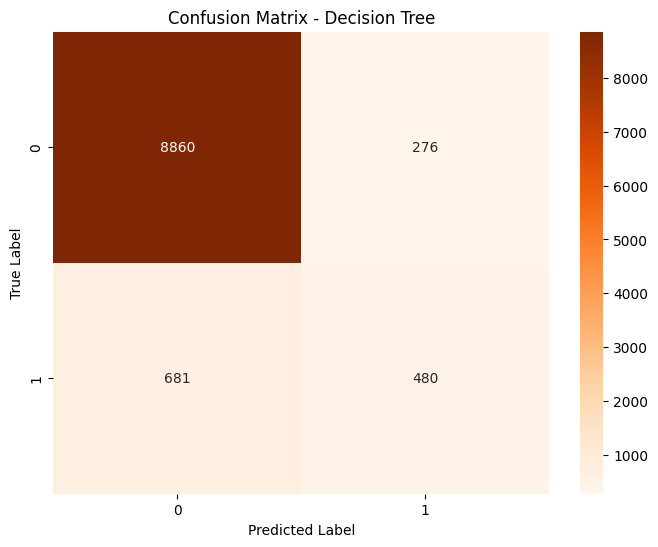

In [59]:
# Build the confusion matrix for Decision Tree
conf_matrix_dtree = confusion_matrix(y_test, dtree_estimator.predict(X_test))
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_dtree, annot=True, fmt='d', cmap='Oranges')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Decision Tree')

Text(0.5, 1.0, 'Confusion Matrix - Support Vector Machine')

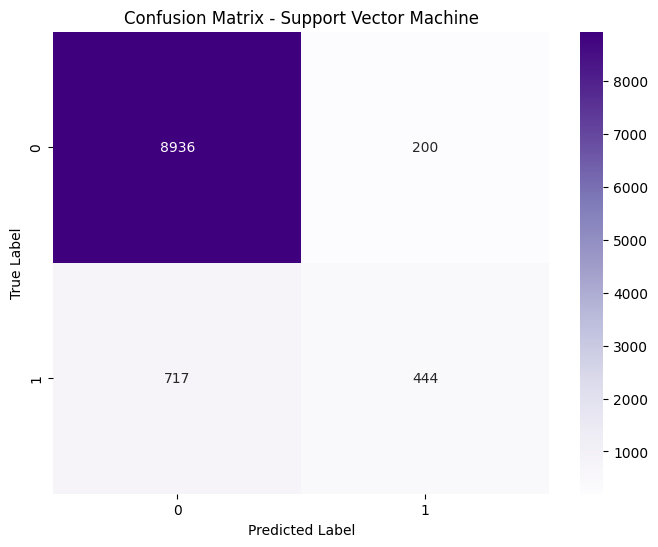

In [60]:
# Build the confusion matrix for SVM
conf_matrix_svm = confusion_matrix(y_test, svm_estimator.predict(X_test))
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Purples')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Support Vector Machine')

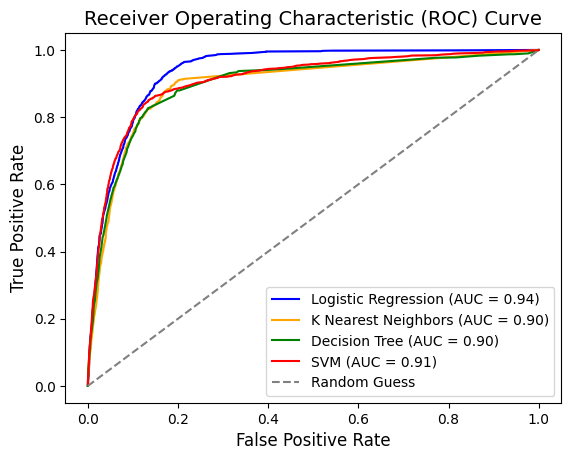

In [ ]:
# Build ROC curves
log_y_proba = log_estimator.predict_proba(X_test)[:, 1]
log_fpr, log_tpr, _ = roc_curve(y_test, log_y_proba)
log_roc_auc = auc(log_fpr, log_tpr)

knn_y_proba = knn_estimator.predict_proba(X_test)[:, 1]
knn_fpr, knn_tpr, _ = roc_curve(y_test, knn_y_proba)
knn_roc_auc = auc(knn_fpr, knn_tpr)

dtree_y_proba = dtree_estimator.predict_proba(X_test)[:, 1]
dtree_fpr, dtree_tpr, _ = roc_curve(y_test, dtree_y_proba)
dtree_roc_auc = auc(dtree_fpr, dtree_tpr)

svm_y_proba = svm_estimator.decision_function(X_test)
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_y_proba)
svm_roc_auc = auc(svm_fpr, svm_tpr)

# Plot ROC curves for the models
sns.lineplot(x=log_fpr, y=log_tpr, label=f"Logistic Regression (AUC = {log_roc_auc:.2f})", color="blue")
sns.lineplot(x=knn_fpr, y=knn_tpr, label=f"K Nearest Neighbors (AUC = {knn_roc_auc:.2f})", color="orange")
sns.lineplot(x=dtree_fpr, y=dtree_tpr, label=f"Decision Tree (AUC = {dtree_roc_auc:.2f})", color="green")
sns.lineplot(x=svm_fpr, y=svm_tpr, label=f"SVM (AUC = {svm_roc_auc:.2f})", color="red")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")
plt.title("Receiver Operating Characteristic (ROC) Curve", fontsize=14)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(loc="lower right", fontsize=10)
plt.show()

##### Questions